<a href="https://colab.research.google.com/github/merrecalde/curso_cuenca_2021/blob/main/representaci%C3%B3n_de_documentos_2da_parte.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook: representacion_documentos_2da_parte.ipynb

En esta notebook se utilizan distintos modelos de representación de documentos con distintas colecciones de datos que son cargadas de diversas formas: 

1. [20 News Group](https://colab.research.google.com/drive/12kMXEMrx7yPMaDq-ehq-1B5d8nsc73nE#scrollTo=HfAifJPQ66Vy)

En este caso se utiliza la colección *20 News Group*, cargándola mediante la facilidad "fetch_20newsgroups" provista por sci-kit learn. En este caso, además de la representación tf-idf clásica, se muestran dos ejemplos de reducción de dimensionalidad, uno mediante *selección de características* ($\chi^2$) y el otro mediante *transformación de características* (LSA)

2. [Colección oficialistas-opositores](#seccion2)

Esta es una colección en español con documentos periodísticos argentinos. Para su análisis se utilizan dos representaciones de documentos. Una con características "estáticas" obtenidas de LIWC y otra con características dinámicas obtenidas con los vectorizadores de scikit-learn


**Archivos necesarios para ejecutar esta notebook:** En el caso de 20NewsGroup lo descarga directamente de sklearn (en formato Bunch), en el caso de los archivos LIWC, los descarga remotamente desde un Github (convirtiéndolos de csv a data frame) por lo que sólo se requiere "subir" el archivo 
*ofi_opo_UTF_ok.tar.gz*. Aquí se lo hace con un comando dentro de la notebook, pero se podría haber hecho directamente desde el panel izquierdo del Colab.






<img src="https://images.freeimages.com/images/small-previews/c8e/books-1478715.jpg" alt="drawing" width="350"/> 
<img src="https://image.shutterstock.com/image-vector/shopping-bag-word-cloud-600w-137359802.jpg" alt="drawing" width="350"/>


<a id='section2'></a>
#1) 20 News Group

In [ ]:
import logging
import numpy as np
from time import time
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

from sklearn.pipeline import Pipeline


In [ ]:
# #############################################################################
# Cargar algunas categorías desde el conjunto de entrenamiento
categories = None
# Esto carga todas las categorías de la colección

# Si quiciera trabajar con algunas categorías en particular, especificarlas en 
# la variable categories 

# Ejemplo:
# categories = [ 'alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']


In [ ]:
# Especificar filtrados
remove = ('headers', 'footers', 'quotes')

# Si no se remueve nada hacer
# remove = ()
     

In [ ]:
print("Cargando la colección 20 newsgroups (subconjunto de entrenamiento) para las categorías:")
print(categories if categories else "all")

datos = fetch_20newsgroups(subset='train', categories=categories,
                                shuffle=True, random_state=42,
                                remove=remove)
print('datos cargados \n \n ')
print("El objeto retornado por la operación de carga es de tipo:", type(datos))

# order of labels in `target_names` can be different from `categories`
target_names = datos.target_names


def size_mb(docs):
    return sum(len(s.encode('utf-8')) for s in docs) / 1e6


datos_size_mb = size_mb(datos.data)

print("%d documentos - %0.3fMB (en el conjunto cargado)" % (
    len(datos.data), datos_size_mb))
print("%d categorías" % len(target_names))
print()


Cargando la colección 20 newsgroups (subconjunto de entrenamiento) para las categorías:
all
datos cargados 
 
 
El objeto retornado por la operación de carga es de tipo: <class 'sklearn.utils.Bunch'>
11314 documentos - 13.782MB (en el conjunto cargado)
20 categorías



In [ ]:
y = datos.target

print("Extrayendo las características de los datos cargados usando un vectorizador sparse")
t0 = time()

vectorizador = TfidfVectorizer(sublinear_tf=True, max_df=0.5,
                                 stop_words='english')
X = vectorizador.fit_transform(datos.data)
duration = time() - t0
print("realizado en %fs a %0.3fMB/s" % (duration, datos_size_mb / duration))
print("n_muestras: %d, n_features: %d" % X.shape)
print()

# mapping desde las features enteras al string del token original 
feature_names = vectorizador.get_feature_names()


Extrayendo las características de los datos cargados usando un vectorizador sparse
realizado en 5.107120s a 2.699MB/s
n_muestras: 11314, n_features: 101322



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
print("Tipo de los datos vectorizados (Matriz X): ", type(X))
print("Tipo del arreglo target (vector y): ", type(y))
print("... y los tamaños de X e y")
print(X.shape)
print(y.shape)

Tipo de los datos vectorizados (Matriz X):  <class 'scipy.sparse.csr.csr_matrix'>
Tipo del arreglo target (vector y):  <class 'numpy.ndarray'>
... y los tamaños de X e y
(11314, 101322)
(11314,)


##1.1) Selección de características (test $\chi^2$)




In [ ]:
# Selección de características

print("Extrayendo las 1000 mejores features por un test chi-squared")
t0 = time()
ch2 = SelectKBest(chi2, k=1000)
X_chi2 = ch2.fit_transform(X, y)
if feature_names:
    # keep selected feature names
    feature_names = [feature_names[i] for i
                     in ch2.get_support(indices=True)]
print("done in %fs" % (time() - t0))
print()

if feature_names:
    feature_names = np.asarray(feature_names)


def trim(s):
    """Trim string to fit on terminal (assuming 80-column display)"""
    return s if len(s) <= 80 else s[:77] + "..."


# #############################################################################


Extrayendo las 1000 mejores features por un test chi-squared
done in 0.403967s



In [ ]:
print("100 primeras features seleccionadas (ordenadas alfabéticamente)", feature_names[:100])
print("\n")
print("El tamaño de los datos reducidos (con las columnas seleccionadas):", X_chi2.shape)



100 primeras features seleccionadas (ordenadas alfabéticamente) ['00' '040' '1280x1024' '1914' '1948' '256' '386' '3d' '3do' '486' '512k'
 '610' '650' '68040' '68070' '8051' '80ns' 'aaa' 'abc' 'adam' 'adaptec'
 'adb' 'adl' 'administration' 'advance' 'aerospace' 'agencies' 'agency'
 'ahl' 'algorithm' 'algorithms' 'allah' 'allen' 'allergic' 'alomar'
 'amendment' 'ames' 'amiga' 'amorc' 'amp' 'anecdotal' 'animation' 'anti'
 'antibiotic' 'apollo' 'apostles' 'apple' 'application' 'apps' 'arab'
 'arabs' 'arafat' 'arena' 'arf' 'argic' 'argument' 'armenia' 'armenian'
 'armenians' 'arms' 'arrogance' 'asking' 'assault' 'astronomy' 'astros'
 'atf' 'atheism' 'atheist' 'atheists' 'athena' 'ati' 'attacks' 'audio'
 'auto' 'autos' 'azerbaijan' 'azerbaijani' 'azeri' 'azeris' 'b30' 'baerga'
 'ball' 'banks' 'baseball' 'bat' 'batf' 'batting' 'bd' 'beat' 'beauchaine'
 'belfour' 'belief' 'beliefs' 'believe' 'bible' 'biblical' 'bike' 'biker'
 'bikers' 'bikes']


El tamaño de los datos reducidos (con las colum

### Graficando las features de mayor $\chi^2$



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


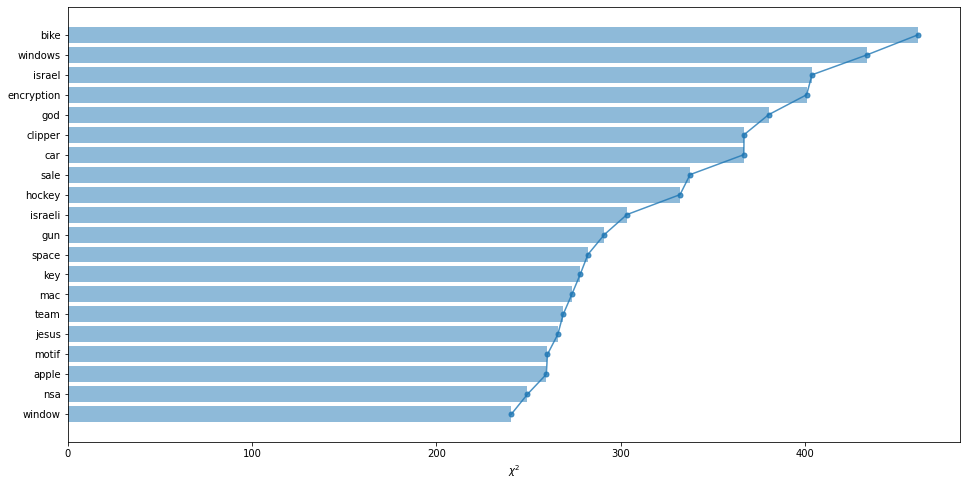

In [ ]:
chi2score = chi2(X, y)[0]
plt.figure(figsize=(16,8))
scores = list(zip(vectorizador.get_feature_names(), chi2score))
chi2 = sorted(scores, key=lambda x:x[1])
topchi2 = list(zip(*chi2[-20:]))
x = range(len(topchi2[1]))
labels = topchi2[0]
plt.barh(x,topchi2[1], align='center', alpha=0.5)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels)
plt.xlabel('$\chi^2$')
plt.show();

##1.2) Transformación de características (LSA)

In [ ]:
vectorizador2 = TfidfVectorizer(max_df=0.5, min_df=2, stop_words='english')
X2 = vectorizador2.fit_transform(datos.data)

print("hecho en %fs" % (time() - t0))
print("n_muestras: %d, n_features: %d" % X.shape)
print()

print("Realizando reducción de la dimensionalidad con LSA")
t0 = time()
# Los resultados del Vectorizer están normalizados. Dado que los resultados de LSA/SVD 
# no son normalizados, rehacemos la normalización.
svd = TruncatedSVD(50)
normalizer = Normalizer(copy=False) #El normalizador es opcional
lsa = make_pipeline(svd, normalizer)

X_lsa = lsa.fit_transform(X2)

print("done in %fs" % (time() - t0))

explained_variance = svd.explained_variance_ratio_.sum()
print("Explained variance of the SVD step: {}%".format(
    int(explained_variance * 100)))

print()

print("El tamaño de los datos reducidos (con las columnas transformadas):\n", X_lsa.shape)
print("n_muestras: %d, n_features: %d" % X_lsa.shape)

hecho en 6.483607s
n_muestras: 11314, n_features: 101322

Realizando reducción de la dimensionalidad con LSA
done in 4.592134s
Explained variance of the SVD step: 6%

El tamaño de los datos reducidos (con las columnas transformadas):
 (11314, 50)
n_muestras: 11314, n_features: 50


#2) Colección *oficialistas* y *opositores*

Esta colección de documentos se describe [aqui](https://journal.info.unlp.edu.ar/JCST/article/view/1348/990), y consiste en 196 textos periodísticos escritos en el período de gobierno 201-2015, siendo la mitad de periodistas que adherian a las políticas del gobierno de aquellos años (oficialistas) y la otra mitad de periodistas opositores a dichas políticas. En este caso, se comienza primero con una representación con 90 features estáticas obtenidas mediante el sistema LIWC. Dicho datos se leen de un archivo en formato "csv" accesible en Github. La misma colección es accedida cargando los textos "crudos", desde un  directorio "ofi_opo_UTF_ok". Este directorio debe estar disponible localmente. Para ello se debe subr el archivo "ofi_opo_UTF_ok.tar.gz" que luego es descomprimido con "tar". Posteriormente, se cargan los documentos "crudos" con la facilidad *load_files* de sci-kit learn. 

 


## 2.1) Features estáticas (LIWC)

In [ ]:
import pandas as pd

In [ ]:
!wget "https://raw.githubusercontent.com/merrecalde/curso_la_plata_2019/master/oficialistas_LIWC.csv"
!wget "https://raw.githubusercontent.com/merrecalde/curso_la_plata_2019/master/opositores_LIWC.csv"
!wget "https://raw.githubusercontent.com/merrecalde/curso_la_plata_2019/master/ofi_opo_LIWC.csv"

--2022-02-12 09:20:59--  https://raw.githubusercontent.com/merrecalde/curso_la_plata_2019/master/oficialistas_LIWC.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64238 (63K) [text/plain]
Saving to: ‘oficialistas_LIWC.csv’

oficialistas_LIWC.c 100%[===================>]  62.73K  --.-KB/s    in 0.01s   

2022-02-12 09:20:59 (4.60 MB/s) - ‘oficialistas_LIWC.csv’ saved [64238/64238]

--2022-02-12 09:21:00--  https://raw.githubusercontent.com/merrecalde/curso_la_plata_2019/master/opositores_LIWC.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response..

In [ ]:
data_ofi = pd.read_csv('oficialistas_LIWC.csv',decimal=',')
data_opo = pd.read_csv('opositores_LIWC.csv',decimal=',')
data_ofi_opo = pd.read_csv('ofi_opo_LIWC.csv',decimal=',')

### Número de palabras (opositor)

In [ ]:
data_opo.head()

,Filename,Segment,WC,WPS,Sixltr,Dic,Funct,TotPron,PronPer,Yo,Nosotro,TuUtd,ElElla,Ellos,PronImp,Articulo,Verbos,VerbAux,Pasado,Present,Futuro,Adverb,Prepos,Conjunc,Negacio,Cuantif,Numeros,Maldec,verbYO,verbTU,verbNOS,verbosEL,verbELLOS,Subjuntiv,VosUtds,formal,informal,verbVos,Social,Familia,...,Tentat,Certeza,Inhib,Incl,Excl,Percept,Ver,Oir,Sentir,Biolog,Cuerpo,Salud,Sexual,Ingerir,Relativ,Movim,Espacio,Tiempo,Trabajo,Logro,Placer,Hogar,Dinero,Relig,Muerte,Asentir,NoFluen,Relleno,AllPunc,Period,Comma,Colon,SemiC,QMark,Exclam,Dash,Quote,Apostro,Parenth,OtherP
0,al01.txt,1,1156,23.59,23.53,68.86,46.11,13.15,8.48,0.09,0.00,0.17,8.30,3.37,4.67,12.37,8.48,0.26,2.51,4.67,0.0,3.03,15.05,6.57,1.56,0.95,1.38,0.0,0.43,0.17,0.00,2.16,0.87,0.95,0.17,0.00,0.00,0.0,8.74,0.52,...,1.47,1.56,0.35,6.57,1.47,1.90,0.35,0.26,0.61,1.82,0.78,0.26,0.26,0.87,7.09,2.08,3.37,2.34,2.51,1.30,1.04,0.43,1.04,0.61,0.61,0.35,0.0,0.0,8.91,4.15,3.46,0.26,0.0,0.09,0.0,0.26,0.0,0.0,0.69,0.00
1,al02.txt,1,1097,17.14,23.70,73.20,48.04,13.95,7.93,0.00,0.36,0.64,7.66,2.64,6.02,11.39,10.67,1.19,1.91,7.93,0.0,4.01,13.04,7.93,2.19,1.73,2.28,0.0,0.73,0.00,0.09,3.74,1.37,1.64,0.27,0.09,0.00,0.0,9.30,0.27,...,2.64,0.91,0.64,6.65,1.82,2.64,0.64,0.73,0.27,2.01,0.82,0.27,0.27,1.28,6.93,1.73,4.28,1.91,3.10,3.01,0.36,0.09,1.37,0.36,0.36,0.27,0.0,0.0,9.12,5.65,2.64,0.27,0.0,0.27,0.0,0.00,0.0,0.0,0.00,0.27
2,al03.txt,1,1104,20.83,23.10,72.46,46.83,11.68,6.52,0.09,0.91,0.27,6.25,2.36,5.16,12.59,8.15,0.63,1.54,5.80,0.0,2.81,15.85,6.34,1.54,1.36,1.27,0.0,0.18,0.00,0.09,2.72,0.18,1.09,0.18,0.00,0.00,0.0,9.33,0.54,...,1.72,1.09,0.72,7.79,2.17,3.62,0.63,1.72,0.36,1.63,0.63,0.09,0.18,0.82,8.15,1.36,5.25,1.99,2.36,2.26,0.82,0.54,0.91,0.45,0.09,0.18,0.0,0.0,8.61,4.53,3.17,0.45,0.0,0.36,0.0,0.00,0.0,0.0,0.00,0.09
3,al04.txt,1,863,16.28,22.71,70.57,47.51,14.14,7.76,0.35,0.23,1.04,7.18,1.74,6.37,10.89,8.34,0.23,1.51,5.68,0.0,3.59,16.34,5.33,1.62,1.62,1.97,0.0,1.16,0.12,0.23,2.78,0.23,1.51,0.12,0.00,0.23,0.0,8.46,0.23,...,2.90,0.93,0.35,4.87,2.67,1.74,0.46,0.58,0.00,1.27,0.46,0.00,0.00,1.04,8.81,1.51,5.79,2.20,3.59,2.20,0.58,0.58,1.39,0.00,0.12,0.23,0.0,0.0,9.62,4.98,2.90,0.46,0.0,1.27,0.0,0.00,0.0,0.0,0.00,0.00
4,al05.txt,1,1649,18.74,20.92,76.59,49.06,14.25,6.97,0.00,0.73,0.73,6.85,2.30,7.28,12.98,10.73,0.97,2.55,7.58,0.0,4.12,14.61,6.55,1.21,1.82,1.09,0.0,0.85,0.00,0.61,4.18,0.24,1.21,0.00,0.00,0.00,0.0,9.34,0.85,...,2.06,1.70,0.36,6.67,2.91,3.52,0.73,1.33,0.12,2.18,0.73,0.00,0.49,1.21,8.73,0.97,5.70,2.43,2.85,2.49,0.61,0.24,1.09,0.85,0.24,0.24,0.0,0.0,9.22,4.49,3.52,0.36,0.0,0.85,0.0,0.00,0.0,0.0,0.00,0.00


In [ ]:
num_pals_opo = np.array(data_opo['WC'])
print(num_pals_opo)

[1156 1097 1104  863 1649  909  762  839 1161 1168 1078 1230  848 1103
  871  928  749  923 1044 1090 2080 1412 1312 1091  786  931  971  750
  728  648  414  760  610  572  670  583  236  278  459 1019 1002 1042
 1215  895  949  963 1081 1277 1221 1219  931  950 1134  998 1187 1318
 1184 1251 2808 2886 2953 2631 2806 2374  256 2739 3049 2675  648  387
  361 1202  467 2682 2958 3234 3423 3176 1230 1178 1170 1171 1168 1152
 1180 1136 1117 1126 1057 1078 1057 1062 1036 1079 1003  973  891  537]


In [ ]:
print("num_pal_opo: Mean: ", num_pals_opo.mean())
print("num_pal_opo: standard deviation:", num_pals_opo.std())
print("num_pal_opo minimo: ", num_pals_opo.min())
print("num_pal_opo: maximo: ", num_pals_opo.max())

num_pal_opo: Mean:  1243.0102040816328
num_pal_opo: standard deviation: 733.7139588186014
num_pal_opo minimo:  236
num_pal_opo: maximo:  3423


### 2.2) Features dinámicas (BoW)

Para trabajar con los textos "crudos", necesitamos en este caso  

In [1]:
from google.colab import files

print("Subir el archivo ofi_opo_UTF_ok.tar.gz") 

print()

files.upload()  

Subir el archivo ofi_opo_UTF_ok.tar.gz



Saving ofi_opo_UTF_ok.tar.gz to ofi_opo_UTF_ok.tar.gz


{'ofi_opo_UTF_ok.tar.gz': b'\x1f\x8b\x08\x08\xd3^\x83`\x00\x03ofi_opo_UTF_ok.tar\x00\xec\xfdM\x8f\x1c\xd7\x95-\x0c\xf7\xb8\x80\xfa\x0f!M\x1e\x12H\xb3I\xea\xcb.\x0f\x08\x8a\xa4>l\x92\xa2EI\xb7\xf5L.NfFeE92"\x1d\x91\x91\xcd\xac\x91\xa7\xef\xd8\x93\xdb/\xfa\x0e8\xb9\x00\x07\x1a443^\xc0\x80\xea\x9f\xf8\x97\xbc{\xad\xb5\xf7\x89\xc8"e\xdf\xe7QYv\xdf\x16\rXdfd\xc4\x89\xf3\xb1?\xd7^\xfb\xd6?\xb7\xa7\xd5\x7fo7\xed\x7f\xff\xf2\x8b\x8f\xfe{\xfb\xdb\x7f\xfe\xa7\xeb\xffs\xdb\xfe|\xf0\xc1\x07\xf8\xef\x9d\x0f\xde\xbb=\xfdo\xfc\xf9\xa7;\xef\xde~\xf7\xf6\xdd\xf7\xdf\xbb\xf3\xfe{\xfft\xfb\xce;\x1f\xdc\xb9\xf3O\xc5{\x7f\x83\xb1\xbc\xf6g\xe8\xb7\xa9+\x8a\x7fZ\xa7nQ\xd6\xed\xf7^\xf7\xd7\xbe\xffO\xfa\xe7\xd6\xd5\xf5\xb7\x7f.\xaaTW6-\xd7\xb5\x17\xfe\x9f\xaf\xff\xfbw\xed\xa3\x9f\xd6\xffG\xf8\xf3\x17\xd7\xff\xfc\xf4\xee\xed[\xdb\x17\xdb\x1f\xf8\x8c\xbf\xbc\xfew\xef\xbe\xf3\xce\x9d\x7f\xba\xf3\xce{w\xee\xdc~\xff\x9d\x0f>\xb0\xcf\xf1\xed\xfb\xffT\xdc\xbe\x967\xfc+\x7f\xfe\x8b\xaf\xff\x97M\xb1i\x97e\xd7\xf6m\xb1N

In [2]:
! gunzip ofi_opo_UTF_ok.tar.gz
! tar -xvf ofi_opo_UTF_ok.tar

./ofi_opo_UTF_ok/
./ofi_opo_UTF_ok/oficialista/
./ofi_opo_UTF_ok/oficialista/jf20.txt
./ofi_opo_UTF_ok/oficialista/jl20.txt
./ofi_opo_UTF_ok/oficialista/sr02.txt
./ofi_opo_UTF_ok/oficialista/jf01.txt
./ofi_opo_UTF_ok/oficialista/jf012.txt
./ofi_opo_UTF_ok/oficialista/jf02.txt
./ofi_opo_UTF_ok/oficialista/jf03.txt
./ofi_opo_UTF_ok/oficialista/jf04.txt
./ofi_opo_UTF_ok/oficialista/jf05.txt
./ofi_opo_UTF_ok/oficialista/jf06.txt
./ofi_opo_UTF_ok/oficialista/jf07.txt
./ofi_opo_UTF_ok/oficialista/jf08.txt
./ofi_opo_UTF_ok/oficialista/jf09.txt
./ofi_opo_UTF_ok/oficialista/jf10.txt
./ofi_opo_UTF_ok/oficialista/jf11.txt
./ofi_opo_UTF_ok/oficialista/jf13.txt
./ofi_opo_UTF_ok/oficialista/jf14.txt
./ofi_opo_UTF_ok/oficialista/jf15.txt
./ofi_opo_UTF_ok/oficialista/jf16.txt
./ofi_opo_UTF_ok/oficialista/jf17.txt
./ofi_opo_UTF_ok/oficialista/jf18.txt
./ofi_opo_UTF_ok/oficialista/jf19.txt
./ofi_opo_UTF_ok/oficialista/jl01.txt
./ofi_opo_UTF_ok/oficialista/jl02.txt
./ofi_opo_UTF_ok/oficialista/jl03.txt
.

In [ ]:
# Otra alternativa hubiera sido tener el Directorio en Drive, y montarlo 

# from google.colab import drive
# drive.mount('/content/gdrive')

# import os
# os.chdir("/content/gdrive/My Drive")


In [ ]:
from sklearn.datasets import load_files

articulos_corpus = load_files("ofi_opo_UTF_ok",encoding='utf-8')
# load_files returns a bunch, containing training texts and training labels
text_artic, clase_artic = articulos_corpus.data, articulos_corpus.target
print("type de lo que devuelve load_files: {}".format(type(articulos_corpus)))
print("type of text_artic: {}".format(type(text_artic)))
print("type of clase_artic: {}".format(type(text_artic)))
print("length of text_artic: {}".format(len(text_artic)))
print("text_artic[0]:\n{}".format(text_artic[0]))


In [ ]:
num_pals = 0
for str in text_artic:
    num_pals = num_pals + len(str.split())
print('Número de palabras en el Data Set Original')
print(num_pals)

In [ ]:
# Apply a first round of text cleaning techniques
import re
import string

def clean_text(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    #text = text.lower()
    text = re.sub('\r\n', ' ', text)
    text = re.sub('\ufeff', ' ', text)
    #text = re.sub('\[.*?\]', ' ', text)
    #text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub('\w*\d\w*', ' ', text)
    return text

In [ ]:
text_artic = [clean_text(doc) for doc in text_artic]

In [ ]:
num_pals = 0
for str in text_artic:
    num_pals = num_pals + len(str.split())
print(num_pals)

280343


In [ ]:
vect = CountVectorizer().fit(text_artic) # Esto ya lo había hecho antes en dos pasos
X_train = vect.transform(text_artic)
print("X_train:\n{}".format(repr(X_train)))

X_train:
<196x24323 sparse matrix of type '<class 'numpy.int64'>'
	with 99998 stored elements in Compressed Sparse Row format>


In [ ]:
# Esto también ya lo había hecho
feature_names = vect.get_feature_names()
print("Number of features: {}".format(len(feature_names)))
print("First 20 features:\n{}".format(feature_names[:20]))
print("Features 20010 to 20030:\n{}".format(feature_names[20010:20030]))
print("Every 2000th feature:\n{}".format(feature_names[::2000]))

Number of features: 24323
First 20 features:
['aa', 'aaa', 'aanto', 'abaca', 'abajo', 'abal', 'abalanzan', 'abandona', 'abandonaba', 'abandonaban', 'abandonado', 'abandonados', 'abandonar', 'abandonara', 'abandonarlo', 'abandonaron', 'abandonará', 'abandono', 'abandonó', 'abanico']
Features 20010 to 20030:
['republica', 'republicana', 'republicanas', 'republicano', 'republicanos', 'repudiable', 'repudiada', 'repudiemos', 'repudio', 'repudios', 'repudió', 'repuesta', 'repugnancia', 'repugnante', 'repugne', 'repulsa', 'repulsivos', 'repunte', 'repuso', 'reputación']
Every 2000th feature:
['aa', 'arrollada', 'cesan', 'cuarto', 'docentes', 'expliquemos', 'hábilmente', 'licencia', 'novelas', 'posta', 'reproducción', 'sujeto', 'volantazo']


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


#### Ahora hago una vectorización de los documentos, con una frecuencia mínima de 5 documentos, y luego elimino las palabras de paro

In [ ]:
vect = CountVectorizer(min_df=5).fit(text_artic)
X_train = vect.transform(text_artic)
print("X_train with min_df: {}".format(repr(X_train)))



X_train with min_df: <196x4155 sparse matrix of type '<class 'numpy.int64'>'
	with 68383 stored elements in Compressed Sparse Row format>


In [ ]:
feature_names = vect.get_feature_names()

print("First 50 features:\n{}".format(feature_names[:50]))
print("Features 1510 to 1530:\n{}".format(feature_names[1510:1530]))
print("Every 700th feature:\n{}".format(feature_names[::700]))

First 50 features:
['abajo', 'abal', 'abandonar', 'abarca', 'abierta', 'abiertas', 'abierto', 'abiertos', 'abogada', 'abogado', 'abogados', 'aborto', 'abrazo', 'abre', 'abrieron', 'abril', 'abrir', 'abrió', 'abría', 'absoluta', 'absolutamente', 'absurda', 'absurdo', 'abuelas', 'abunda', 'abuso', 'acaba', 'acabó', 'acaso', 'acceder', 'acceso', 'accionar', 'acciones', 'acción', 'acepción', 'acepta', 'aceptación', 'aceptan', 'aceptar', 'aceptaron', 'aceptó', 'acerca', 'acercamiento', 'aclara', 'aclarar', 'aclaró', 'acompañada', 'acompañan', 'acompañó', 'acontecimiento']
Features 1510 to 1530:
['excelente', 'excepcional', 'excepciones', 'excepción', 'exceso', 'exclusión', 'excusa', 'exhibe', 'exhibir', 'exige', 'exista', 'existe', 'existen', 'existencia', 'existir', 'existió', 'existía', 'existían', 'expectativas', 'expediente']
Every 700th feature:
['abajo', 'condenado', 'escritorio', 'jornada', 'parecida', 'salvar']


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### Stop-words (en español, de NLTK)

In [ ]:
import nltk
nltk.download('stopwords')

# We are going to create a document-term matrix using CountVectorizer, and exclude common Spanish stop words
from nltk.corpus import stopwords 

stop_words = set(stopwords.words('spanish')) 

print("Number of stop words: {}".format(len(stop_words)))
print("Number of stop words: {}".format(stop_words))
print("Every 10th stopword:\n{}".format(list(stop_words)[::10]))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Number of stop words: 313
Number of stop words: {'estoy', 'habíais', 'tuvieran', 'serás', 'hasta', 'nuestra', 'te', 'más', 'otros', 'el', 'fueses', 'donde', 'estuviese', 'estar', 'sentido', 'otra', 'lo', 'habido', 'quien', 'vosotros', 'habría', 'míos', 'le', 'tengáis', 'porque', 'hubisteis', 'mis', 'habidas', 'habían', 'unos', 'tendrías', 'sobre', 'su', 'has', 'mías', 'tengamos', 'esto', 'él', 'ha', 'siente', 'tanto', 'seremos', 'estés', 'estaremos', 'ellos', 'tenida', 'otras', 'soy', 'durante', 'estas', 'con', 'habríamos', 'éramos', 'del', 'suyo', 'hubiéramos', 'tendríamos', 'estuvisteis', 'seríais', 'estarán', 'tuvimos', 'estuviste', 'estarías', 'estén', 'muchos', 'tiene', 'fueron', 'tendrás', 'hubieran', 'ella', 'fuerais', 'serían', 'habíamos', 'hay', 'seáis', 'tened', 'están', 'seríamos', 'nada', 'habidos', 'estuvieron', 'tuvisteis', 'habéis', 'estuviera', 'nos', 'está', '

#### Ahora vectorizo sin las palabras de paro

In [ ]:
vect = CountVectorizer(min_df=5,stop_words=stop_words).fit(text_artic)
X_train = vect.transform(text_artic)
print("X_train with min_df: {}".format(repr(X_train)))

X_train with min_df: <196x3981 sparse matrix of type '<class 'numpy.int64'>'
	with 55044 stored elements in Compressed Sparse Row format>


#### y lo mismo puedo hacer con otros vectorizadores

In [ ]:
vect = TfidfVectorizer(min_df=5,stop_words=stop_words).fit(text_artic)
X_train = vect.transform(text_artic)
print("X_train with min_df: {}".format(repr(X_train)))

X_train with min_df: <196x3981 sparse matrix of type '<class 'numpy.float64'>'
	with 55044 stored elements in Compressed Sparse Row format>
